In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# Set random seed untuk reproducibility
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [ ]:
# Load dataset MNIST
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Data training shape: {x_train.shape}")
print(f"Data testing shape: {x_test.shape}")
print(f"Label training shape: {y_train.shape}")
print(f"Label testing shape: {y_test.shape}")

# Preprocessing data untuk Transfer Learning
def preprocess_data(images, labels):
    # Konversi ke 3 channel (RGB) untuk model pre-trained
    images_rgb = np.stack([images] * 3, axis=-1)

    # Resize ke 32x32 (ukuran minimum untuk banyak model pre-trained)
    images_resized = tf.image.resize(images_rgb, [32, 32]).numpy()

    # Normalisasi ke range [0, 1]
    images_normalized = images_resized / 255.0

    # One-hot encoding labels
    labels_categorical = to_categorical(labels, 10)

    return images_normalized, labels_categorical

# Preprocess data training dan testing
print("Preprocessing data...")
x_train_processed, y_train_processed = preprocess_data(x_train, y_train)
x_test_processed, y_test_processed = preprocess_data(x_test, y_test)

print(f"Data training setelah preprocessing: {x_train_processed.shape}")
print(f"Data testing setelah preprocessing: {x_test_processed.shape}")

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data training shape: (60000, 28, 28)
Data testing shape: (10000, 28, 28)
Label training shape: (60000,)
Label testing shape: (10000,)
Preprocessing data...
Data training setelah preprocessing: (60000, 32, 32, 3)
Data testing setelah preprocessing: (10000, 32, 32, 3)


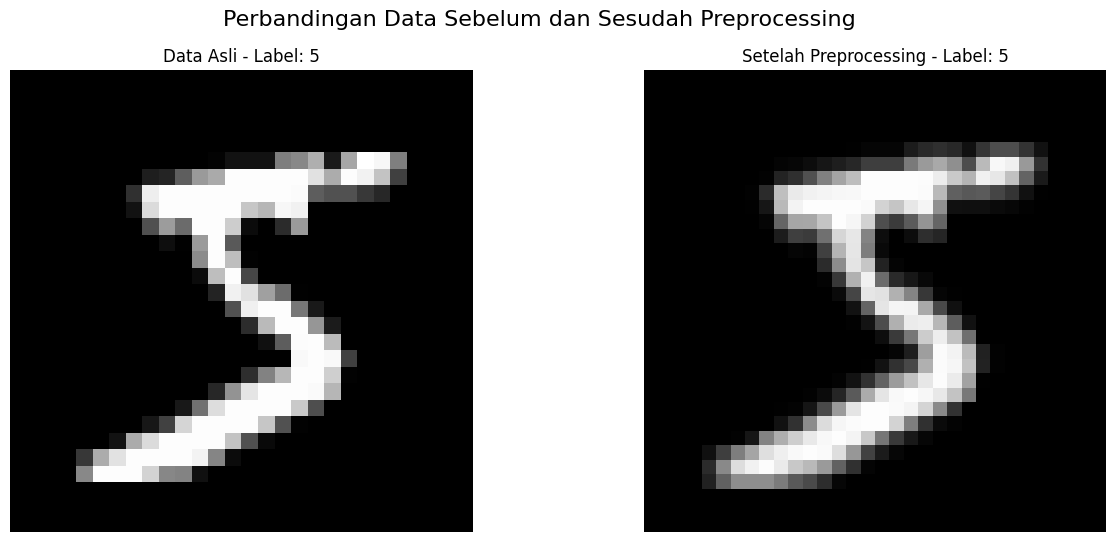

Shape data asli: (28, 28)
Shape setelah preprocessing: (32, 32, 3)
Range nilai pixel: [0.000, 1.000]


In [ ]:
# Visualisasi contoh data setelah preprocessing
plt.figure(figsize=(15, 6))

# Contoh data asli
plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.title(f'Data Asli - Label: {y_train[0]}')
plt.axis('off')

# Contoh data setelah preprocessing
plt.subplot(1, 2, 2)
plt.imshow(x_train_processed[0])
plt.title(f'Setelah Preprocessing - Label: {y_train[0]}')
plt.axis('off')

plt.suptitle('Perbandingan Data Sebelum dan Sesudah Preprocessing', fontsize=16)
plt.show()

print(f"Shape data asli: {x_train[0].shape}")
print(f"Shape setelah preprocessing: {x_train_processed[0].shape}")
print(f"Range nilai pixel: [{x_train_processed.min():.3f}, {x_train_processed.max():.3f}]")

In [ ]:
# Membandingkan beberapa arsitektur pre-trained
def compare_pretrained_models():
    models_info = {
        'MobileNetV2': {
            'input_shape': (32, 32, 3),
            'model': MobileNetV2,
            'params': '3.4M',
            'size': '14MB'
        },
        'VGG16': {
            'input_shape': (32, 32, 3),
            'model': VGG16,
            'params': '138M',
            'size': '528MB'
        },
        'ResNet50': {
            'input_shape': (32, 32, 3),
            'model': ResNet50,
            'params': '25.6M',
            'size': '98MB'
        }
    }

    print("PERBANDINGAN ARSITEKTUR PRE-TRAINED")
    print("="*50)
    for name, info in models_info.items():
        print(f"{name}:")
        print(f"  * Input shape: {info['input_shape']}")
        print(f"  * Parameters: {info['params']}")
        print(f"  * Size: {info['size']}")
        print()

compare_pretrained_models()

# Pilih MobileNetV2 karena efisien dan cocok untuk dataset kecil
print("Memilih MobileNetV2 karena:")
print("* Efisien dalam komputasi")
print("* Cocok untuk dataset berukuran kecil")
print("* Performance yang baik pada berbagai tugas")

PERBANDINGAN ARSITEKTUR PRE-TRAINED
MobileNetV2:
  * Input shape: (32, 32, 3)
  * Parameters: 3.4M
  * Size: 14MB

VGG16:
  * Input shape: (32, 32, 3)
  * Parameters: 138M
  * Size: 528MB

ResNet50:
  * Input shape: (32, 32, 3)
  * Parameters: 25.6M
  * Size: 98MB

Memilih MobileNetV2 karena:
* Efisien dalam komputasi
* Cocok untuk dataset berukuran kecil
* Performance yang baik pada berbagai tugas


In [ ]:
def create_transfer_learning_model(base_model_name='MobileNetV2'):
    """
    Membuat model Transfer Learning dengan base model pre-trained
    """
    # Pilih base model
    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(32, 32, 3)
        )
    elif base_model_name == 'VGG16':
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(32, 32, 3)
        )
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(32, 32, 3)
        )

    # Freeze base model (tidak melatih ulang weights)
    base_model.trainable = False

    # Bangun model lengkap
    inputs = Input(shape=(32, 32, 3))

    # Preprocessing input (sama seperti yang digunakan saat pre-training)
    if base_model_name == 'MobileNetV2':
        x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    elif base_model_name == 'VGG16':
        x = tf.keras.applications.vgg16.preprocess_input(inputs)
    elif base_model_name == 'ResNet50':
        x = tf.keras.applications.resnet50.preprocess_input(inputs)

    # Base model
    x = base_model(x)

    # Custom classifier head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model, base_model

In [ ]:
# Membuat model
print("Membangun model Transfer Learning...")
model, base_model = create_transfer_learning_model('MobileNetV2')

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model berhasil dibuat!")
model.summary()

Membangun model Transfer Learning...


/tmp/ipython-input-3164530819.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model berhasil dibuat!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,858 (9.27 MB)

 Trainable params: 172,874 (675.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

STRUKTUR MODEL TRANSFER LEARNING
Total layers: 8
Base model layers: 154
Trainable layers: 7
Non-trainable layers: 1
Percentage trainable: 87.50%


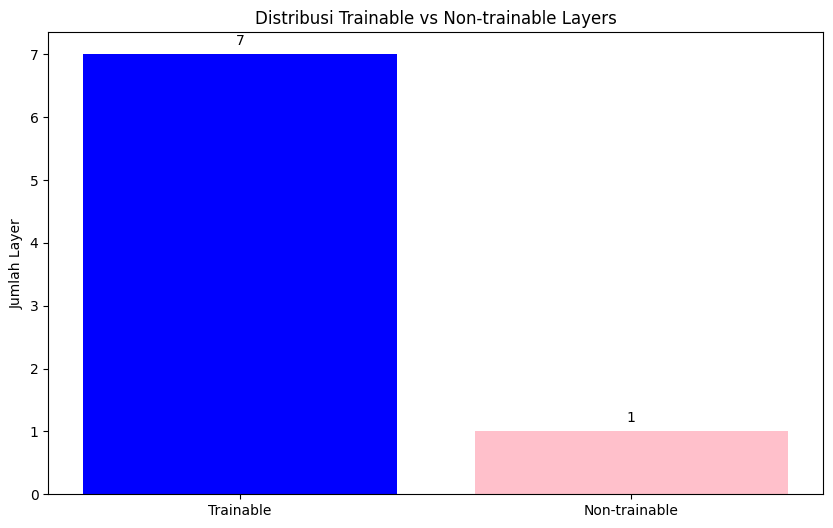

In [ ]:
# Menampilkan layer-layer model
print("STRUKTUR MODEL TRANSFER LEARNING")
print("="*50)

# Hitung jumlah layer yang freeze dan trainable
total_layers = len(model.layers)
base_layers = len(base_model.layers)
trainable_layers = sum([1 for layer in model.layers if layer.trainable])
non_trainable_layers = total_layers - trainable_layers

print(f"Total layers: {total_layers}")
print(f"Base model layers: {base_layers}")
print(f"Trainable layers: {trainable_layers}")
print(f"Non-trainable layers: {non_trainable_layers}")
print(f"Percentage trainable: {(trainable_layers/total_layers)*100:.2f}%")

# Plot distribusi layer
plt.figure(figsize=(10, 6))
layer_types = ['Trainable', 'Non-trainable']
counts = [trainable_layers, non_trainable_layers]

plt.bar(layer_types, counts, color=['blue', 'pink'])
plt.title('Distribusi Trainable vs Non-trainable Layers')
plt.ylabel('Jumlah Layer')
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.show()

In [ ]:
# Setup callbacks untuk training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Buat directory untuk menyimpan model
os.makedirs('saved_models', exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'saved_models/best_transfer_learning_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# Training fase 1: Hanya classifier head
print("FASE 1: Training Classifier Head")
print("="*40)

history_phase1 = model.fit(
    x_train_processed,
    y_train_processed,
    batch_size=30,
    epochs=10,
    validation_data=(x_test_processed, y_test_processed),
    callbacks=callbacks,
    verbose=1
)

FASE 1: Training Classifier Head
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2809 - loss: 1.9339
Epoch 1: val_accuracy improved from -inf to 0.55670, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.2809 - loss: 1.9338 - val_accuracy: 0.5567 - val_loss: 1.2769 - learning_rate: 0.0010
Epoch 2/10
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5125 - loss: 1.3868
Epoch 2: val_accuracy improved from 0.55670 to 0.60970, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.5125 - loss: 1.3867 - val_accuracy: 0.6097 - val_loss: 1.1259 - learning_rate: 0.0010
Epoch 3/10
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5673 - loss: 1.2489
Epoch 3: val_accuracy improved from 0.60970 to 0.65550, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.5673 - loss: 1.2489 - val_accuracy: 0.6555 - val_loss: 1.0019 - learning_rate: 0.0010
Epoch 4/10
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5958 - loss: 1.1686
Epoch 4: val_accuracy improved from 0.65550 to 0.67150, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.5958 - loss: 1.1686 - val_accuracy: 0.6715 - val_loss: 0.9425 - learning_rate: 0.0010
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6180 - loss: 1.1099
Epoch 5: val_accuracy improved from 0.67150 to 0.69040, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.6180 - loss: 1.1099 - val_accuracy: 0.6904 - val_loss: 0.8975 - learning_rate: 0.0010
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6384 - loss: 1.0647
Epoch 6: val_accuracy improved from 0.69040 to 0.70870, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.6384 - loss: 1.0647 - val_accuracy: 0.7087 - val_loss: 0.8561 - learning_rate: 0.0010
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6495 - loss: 1.0271
Epoch 7: val_accuracy improved from 0.70870 to 0.72170, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.6495 - loss: 1.0271 - val_accuracy: 0.7217 - val_loss: 0.8196 - learning_rate: 0.0010
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6617 - loss: 0.9987
Epoch 8: val_accuracy improved from 0.72170 to 0.73740, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.6617 - loss: 0.9987 - val_accuracy: 0.7374 - val_loss: 0.7875 - learning_rate: 0.0010
Epoch 9/10
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6667 - loss: 0.9700
Epoch 9: val_accuracy improved from 0.73740 to 0.73930, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.6667 - loss: 0.9699 - val_accuracy: 0.7393 - val_loss: 0.7686 - learning_rate: 0.0010
Epoch 10/10
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6765 - loss: 0.9487
Epoch 10: val_accuracy did not improve from 0.73930
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.6765 - loss: 0.9487 - val_accuracy: 0.7316 - val_loss: 0.7901 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 9.


In [ ]:
# Fase 2: Fine-tuning dengan unfreeze beberapa layer base model
print("\nFASE 2: Fine-tuning dengan Unfreeze Beberapa Layer")
print("="*50)

# Unfreeze beberapa layer terakhir dari base model
base_model.trainable = True

# Freeze layer awal, unfreeze layer akhir
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile dengan learning rate lebih rendah
model.compile(
    optimizer=Adam(learning_rate=0.0001/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Unfreezed {len(base_model.layers) - fine_tune_at} layer terakhir")
print(f"Total trainable weights: {sum([w.shape.num_elements() for w in model.trainable_weights])}")

# Training fase 2
history_phase2 = model.fit(
    x_train_processed,
    y_train_processed,
    batch_size=30,
    epochs=10,
    validation_data=(x_test_processed, y_test_processed),
    callbacks=callbacks,
    verbose=1
)


FASE 2: Fine-tuning dengan Unfreeze Beberapa Layer
Unfreezed 30 layer terakhir
Total trainable weights: 1699274
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2654 - loss: 18.2470
Epoch 1: val_accuracy did not improve from 0.73930
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 191s 90ms/step - accuracy: 0.2654 - loss: 18.2435 - val_accuracy: 0.1078 - val_loss: 9.4102 - learning_rate: 1.0000e-05
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3921 - loss: 3.8335
Epoch 2: val_accuracy did not improve from 0.73930
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 197s 87ms/step - accuracy: 0.3921 - loss: 3.8332 - val_accuracy: 0.1783 - val_loss: 3.3913 - learning_rate: 1.0000e-05
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4592 - loss: 2.2032
Epoch 3: val_accuracy did not improve from 0.73930
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 177s 88ms/step - accuracy: 0.4592 - loss: 2.2031 - val_accuracy: 0.5861 - val_loss: 1.2806 - learning_rate: 1.0000e-05
Epoch 4/10
2000

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 176s 88ms/step - accuracy: 0.5981 - loss: 1.3048 - val_accuracy: 0.7595 - val_loss: 0.7674 - learning_rate: 1.0000e-05
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6568 - loss: 1.0757
Epoch 6: val_accuracy improved from 0.75950 to 0.80320, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 202s 88ms/step - accuracy: 0.6568 - loss: 1.0756 - val_accuracy: 0.8032 - val_loss: 0.6399 - learning_rate: 1.0000e-05
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7078 - loss: 0.9220
Epoch 7: val_accuracy improved from 0.80320 to 0.82800, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 177s 88ms/step - accuracy: 0.7078 - loss: 0.9220 - val_accuracy: 0.8280 - val_loss: 0.5595 - learning_rate: 1.0000e-05
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7431 - loss: 0.8092
Epoch 8: val_accuracy improved from 0.82800 to 0.84930, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 177s 88ms/step - accuracy: 0.7431 - loss: 0.8092 - val_accuracy: 0.8493 - val_loss: 0.4986 - learning_rate: 1.0000e-05
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7696 - loss: 0.7186
Epoch 9: val_accuracy improved from 0.84930 to 0.86440, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 177s 89ms/step - accuracy: 0.7696 - loss: 0.7186 - val_accuracy: 0.8644 - val_loss: 0.4600 - learning_rate: 1.0000e-05
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7935 - loss: 0.6412
Epoch 10: val_accuracy improved from 0.86440 to 0.87540, saving model to saved_models/best_transfer_learning_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 178s 89ms/step - accuracy: 0.7935 - loss: 0.6412 - val_accuracy: 0.8754 - val_loss: 0.4216 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


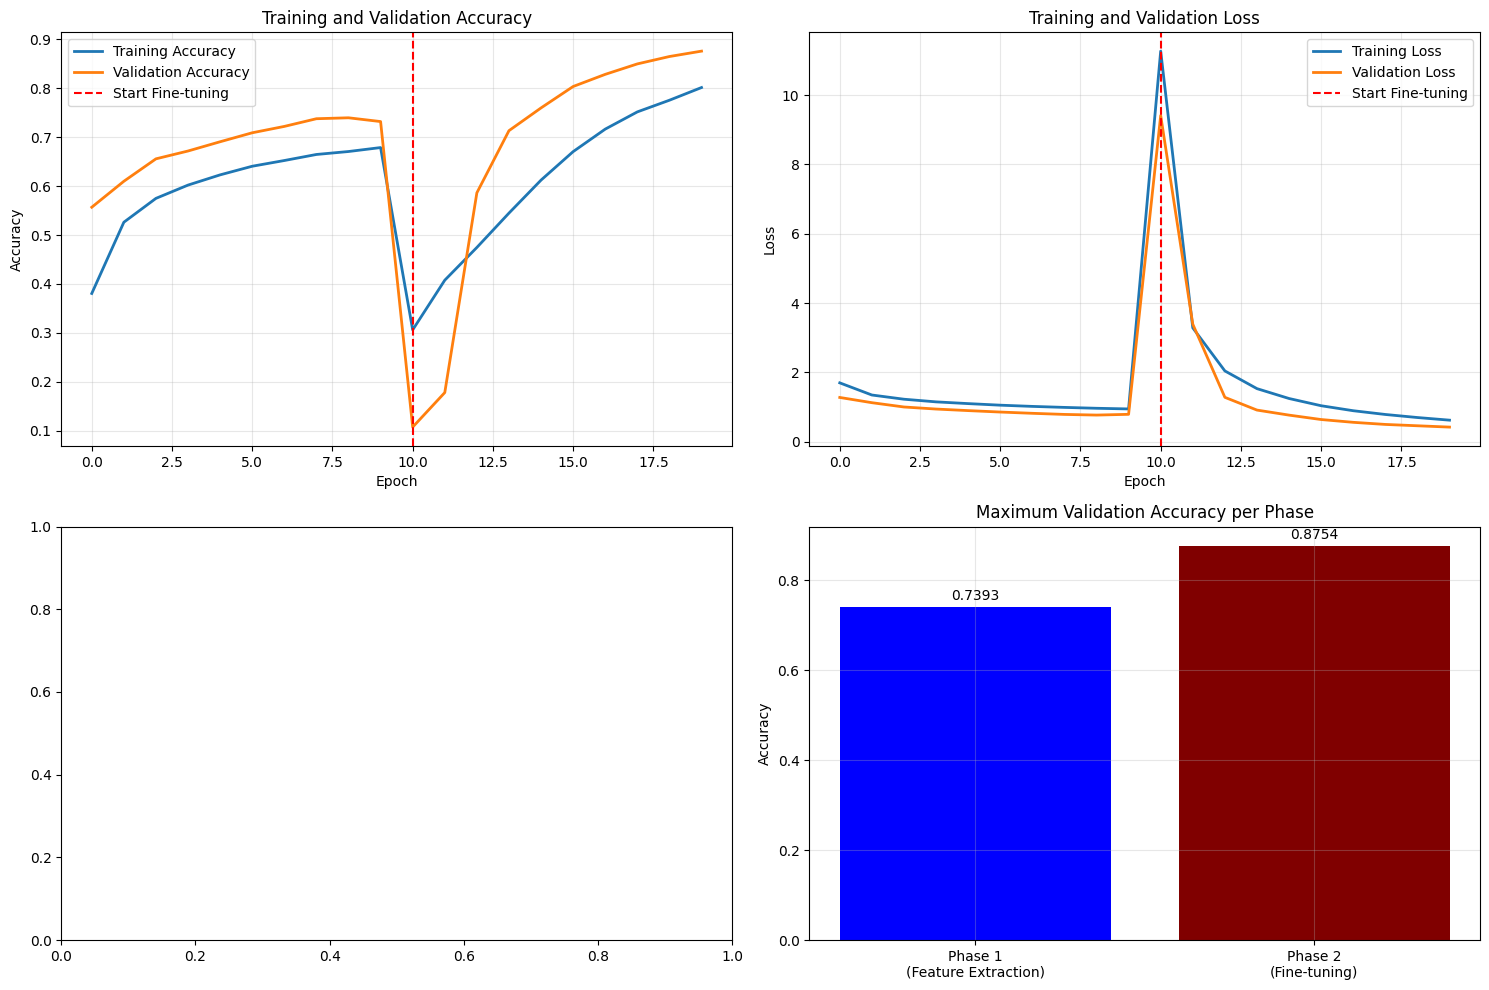

In [ ]:
# Gabungkan history dari kedua fase training
def combine_histories(hist1, hist2):
    combined_history = {}
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]
    return combined_history

combined_history = combine_histories(history_phase1, history_phase2)

# Plot training history
plt.figure(figsize=(15, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(combined_history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--',
            label='Start Fine-tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(combined_history['loss'], label='Training Loss', linewidth=2)
plt.plot(combined_history['val_loss'], label='Validation Loss', linewidth=2)
plt.axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--',
            label='Start Fine-tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot learning rate
plt.subplot(2, 2, 3)
if 'lr' in combined_history:
    plt.plot(combined_history['lr'], label='Learning Rate', linewidth=2, color='purple')
    plt.axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot perbandingan fase
plt.subplot(2, 2, 4)
phases = ['Phase 1\n(Feature Extraction)', 'Phase 2\n(Fine-tuning)']
max_acc_phase1 = max(history_phase1.history['val_accuracy'])
max_acc_phase2 = max(history_phase2.history['val_accuracy'])
max_accuracies = [max_acc_phase1, max_acc_phase2]

plt.bar(phases, max_accuracies, color=['blue', 'maroon'])
plt.title('Maximum Validation Accuracy per Phase')
plt.ylabel('Accuracy')
for i, acc in enumerate(max_accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ANALISIS HASIL TRAINING
Final Training Accuracy: 0.8011
Final Validation Accuracy: 0.8754
Best Validation Accuracy: 0.8754 (epoch 20)
Overfitting: No

Improvement dari Fine-tuning: 0.1438 (14.38%)


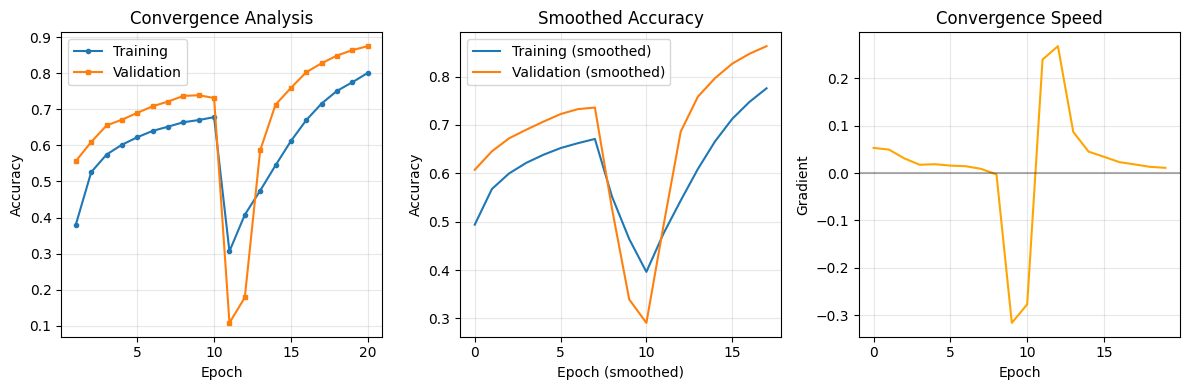

In [ ]:
# Analisis hasil training
print("ANALISIS HASIL TRAINING")
print("="*50)

final_train_acc = combined_history['accuracy'][-1]
final_val_acc = combined_history['val_accuracy'][-1]
best_val_acc = max(combined_history['val_accuracy'])
best_val_epoch = combined_history['val_accuracy'].index(best_val_acc) + 1

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} (epoch {best_val_epoch})")
print(f"Overfitting: {'Yes' if final_train_acc - final_val_acc > 0.05 else 'No'}")

# Hitung improvement dari fase 1 ke fase 2
phase1_final_acc = history_phase1.history['val_accuracy'][-1]
phase2_final_acc = history_phase2.history['val_accuracy'][-1]
improvement = phase2_final_acc - phase1_final_acc

print(f"\nImprovement dari Fine-tuning: {improvement:.4f} ({improvement*100:.2f}%)")

# Plot convergence analysis
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
epochs_range = range(1, len(combined_history['accuracy']) + 1)
plt.plot(epochs_range, combined_history['accuracy'], label='Training', marker='o', markersize=3)
plt.plot(epochs_range, combined_history['val_accuracy'], label='Validation', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
# Smoothing untuk visualisasi yang lebih baik
window = 3
smoothed_train = np.convolve(combined_history['accuracy'], np.ones(window)/window, mode='valid')
smoothed_val = np.convolve(combined_history['val_accuracy'], np.ones(window)/window, mode='valid')
plt.plot(smoothed_train, label='Training (smoothed)')
plt.plot(smoothed_val, label='Validation (smoothed)')
plt.xlabel('Epoch (smoothed)')
plt.ylabel('Accuracy')
plt.title('Smoothed Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Gradient of accuracy (convergence speed)
grad_acc = np.gradient(combined_history['val_accuracy'])
plt.plot(grad_acc, color='orange')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Gradient')
plt.title('Convergence Speed')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

EVALUASI MODEL PADA TEST SET
Test Loss: 0.4216
Test Accuracy: 0.8753
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       980
           1       0.99      0.98      0.99      1135
           2       0.79      0.78      0.79      1032
           3       0.87      0.86      0.86      1010
           4       0.84      0.88      0.86       982
           5       0.86      0.82      0.84       892
           6       0.88      0.94      0.91       958
           7       0.88      0.89      0.89      1028
           8       0.89      0.79      0.84       974
           9       0.81      0.86      0.84      1009

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000



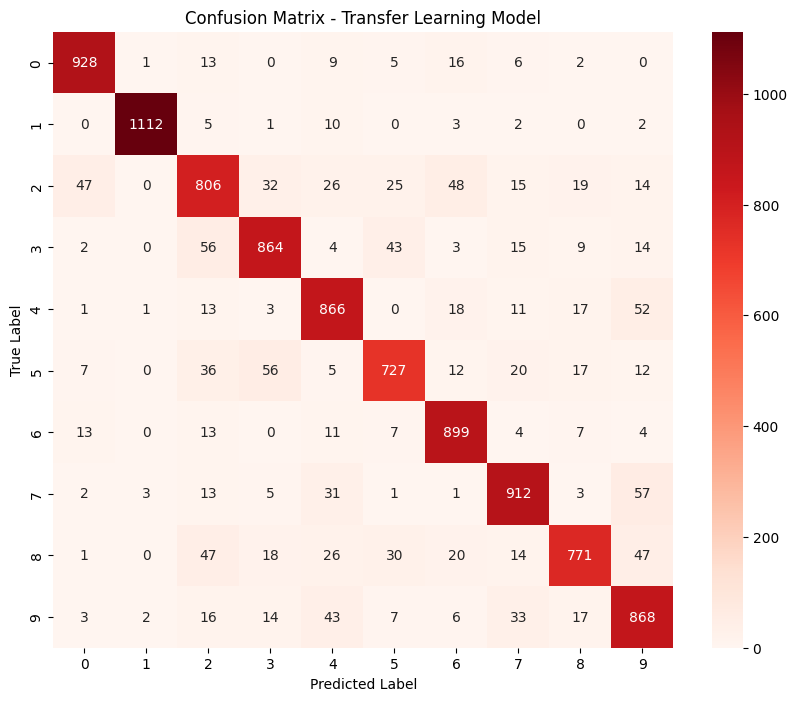

In [ ]:
# Evaluasi model pada test set
print("EVALUASI MODEL PADA TEST SET")
print("="*40)

test_loss, test_accuracy = model.evaluate(x_test_processed, y_test_processed, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Prediksi pada test set
y_pred = model.predict(x_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_processed, axis=1)

# Classification report
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Transfer Learning Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Load model CNN dari bab sebelumnya untuk perbandingan
try:
    cnn_model = keras.models.load_model('mnist_cnn_model.h5')

    # Evaluate CNN model
    x_test_cnn = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(x_test_cnn, y_test, verbose=0)

    print("\nPERBANDINGAN MODEL")
    print("="*40)
    print(f"Transfer Learning Model - Test Accuracy: {test_accuracy:.4f}")
    print(f"CNN Model dari Awal - Test Accuracy: {cnn_test_accuracy:.4f}")

    # Plot perbandingan
    models = ['CNN dari Awal', 'Transfer Learning']
    accuracies = [cnn_test_accuracy, test_accuracy]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, accuracies, color=['blue', 'orange'])
    plt.ylabel('Test Accuracy')
    plt.title('Perbandingan Akurasi Model')
    plt.ylim(0, 1)

    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)
    plt.show()

except:
    print("Model CNN dari sebelumnya ga ditemukan")

Model CNN dari sebelumnya ga ditemukan


In [ ]:
# Simpan model final
model.save('saved_models/final_transfer_learning_model.h5')
print("Model final telah disimpan!")

# Simpan training history
import pickle
with open('saved_models/training_history.pkl', 'wb') as f:
    pickle.dump(combined_history, f)

print("Training history telah disimpan!")

# Ringkasan hasil
print("\n" + "="*50)
print("RINGKASAN IMPLEMENTASI TRANSFER LEARNING")
print("="*50)
print(f"Arsitektur: MobileNetV2")
print(f"Input Shape: (32, 32, 3)")
print(f"Training Strategy: Two-phase (Feature Extraction + Fine-tuning)")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Total Epochs: {len(combined_history['accuracy'])}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("TERIMAKASIH, MATUR NUWUN!")

Model final telah disimpan!
Training history telah disimpan!

RINGKASAN IMPLEMENTASI TRANSFER LEARNING
Arsitektur: MobileNetV2
Input Shape: (32, 32, 3)
Training Strategy: Two-phase (Feature Extraction + Fine-tuning)
Final Test Accuracy: 0.8753
Total Epochs: 20
Best Validation Accuracy: 0.8754
TERIMAKASIH, MATUR NUWUN!
